In [1]:
import os, json
import ruamel.yaml as yaml
import numpy as np
import matplotlib
from matplotlib import transforms
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
import tikzplotlib

from monty.json import MontyDecoder, MontyEncoder
from quotas.core import QuotasCalculator
from pymatgen import Element, Spin
from pymatgen.electronic_structure.plotter import DosPlotter

from support_functions import get_smeared_densities, find_nearest

data_dir = "../data"
figures_dir = "../../../figures/quotas"

# Load the experimental data
with open(os.path.join(data_dir, "experimental_data.json"), "r") as file:
    exp_data = json.loads(file.read(), cls=MontyDecoder)

# Load the dictionary of all the structures for which we have calculated the required properties
with open(os.path.join(data_dir, "structure_dict.yaml"), "r") as file:
    structure_dict = yaml.safe_load(file.read())

In [2]:
# Define the effective ionization energies of the rare gas ions
ionization_energies = {
    "He": 24.56 - 2,
    "Ne": 21.56 - 1,
    "Ar": 15.76 - 0.5,
    "Kr": 12.00,
    "Xe": 10.13
}

# Set the density smearing for the figures
density_smearing = 0.2

def compare_to_exp(element, surface, ion, plasmon_pars=None,
                   smearing=0.01, output_file="temp.tex"):
    
    quotas = QuotasCalculator.from_file(
        os.path.join(data_dir, element + "_" + surface + "_pbe.json"),
        energy_spacing_override=0.01
    )
    if plasmon_pars == "None":
        quotas._surf_plas_prob = None
    elif plasmon_pars is not None:
        quotas.set_up_plasmon_probabilities(**plasmon_pars)

    calc_see = quotas.calculate_yield(ionization_energies[ion])
    exp_see = exp_data[element][ion]

    rc_font_dict = {"size": 20, "family": "sans-serif", 
                    "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
    plt.rc("font", **rc_font_dict)

    # Plot the yield densities
    fig, ax = plt.subplots()
    ax.plot(exp_see["energy"], exp_see["yield"], "o", 
            color="#11557C", markersize=1.5)
    ax.plot(calc_see["energy"], 
             get_smeared_densities(calc_see["energy"], 
                                   calc_see["yield"]*1e3, smearing),
            color="k")

    font_dict = {"size": 20, "family": "sans-serif", "name": 'DejaVu Sans'}

    # Configure the axes
    ax.set_xlim([0, max(exp_see["energy"])])
    ax.set_xlabel(r"$\varepsilon_k$ (eV)")
    ax.set_ylabel(r"$10^3 N_0 (E)$")
    ax.set_title(ion + r"$^+ \rightarrow$" + element + "(" + surface + ")", 
                 fontdict=font_dict)
    plt.legend(["Experiment", "Calculation"], fontsize=14)
    tikzplotlib.save(output_file)

# QUOTAS-Figures

In this notebook we'll generate the figures for the QUOTAS chapter of the thesis. The notebook is structure to follow the order of the figures in the corresponding chapter:

- [Semiconductors](#Semiconductors)
- [Metals](#Metals)
- [Plasmons](#Plasmons)

## Semiconductors

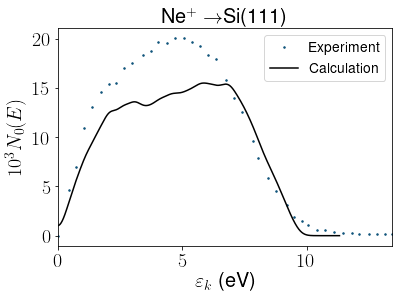

In [3]:
compare_to_exp("Si", "111", "Ne", 
               plasmon_pars="None",
               smearing=density_smearing,
               output_file=os.path.join(figures_dir, "HeGe_results.tex"))

## Metals

To introduce the need for plasmons, we want to show the result of our model for Mg without any plasmonic excitations.

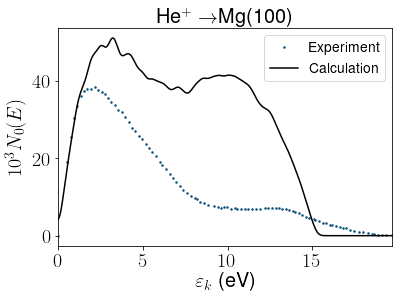

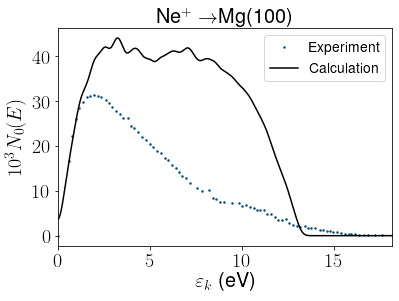

In [4]:
compare_to_exp("Mg", "100", "He", 
               plasmon_pars={"bulk_parameter": 0, "surface_parameter": 0},
               smearing=density_smearing,
               output_file=os.path.join(figures_dir, "HeMg_noplasmon.tex"))

compare_to_exp("Mg", "100", "Ne", 
               plasmon_pars={"bulk_parameter": 0, "surface_parameter": 0},
               smearing=density_smearing,
               output_file=os.path.join(figures_dir, "NeMg_noplasmon.tex"))

## Plasmons

Here the figures to explain the influence of the plasmon excitations on the yield results are generated.

#### DOS of Mg (100)

To demonstrate the need for another plasmon excitation mechanism other than the resonant surface one, we want to plot the DOS of Mg relative to the vacuum level, to demonstrate that a resonant mechanism would have very little effect on the calculations.

In [5]:
element = "Mg"
surface = "100"

quotas = QuotasCalculator.from_file(
    os.path.join(data_dir, element + "_" + surface + "_pbe.json")
)

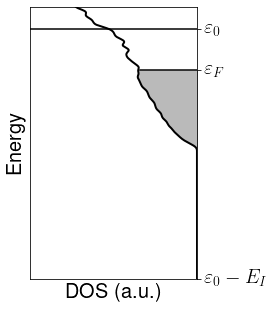

In [6]:
rc_dict = {"font.size": 20, "font.family": "sans-serif", 
           "font.sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}

plt.rcParams.update(rc_dict)

fig, ax = plt.subplots(figsize=(3, 5)); fig.patch.set_alpha(0.)

base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

fermi_dos = quotas.cdos.get_interpolated_value(quotas.cdos.efermi)[Spin.up]
fermi_index = find_nearest(quotas.energies, quotas.cdos.efermi)
densities = get_smeared_densities(quotas.energies, quotas.dos, 0.2)

ax.fill_between(quotas.energies, densities, 
                where=quotas.energies < quotas.cdos.efermi,
                transform=rot + base, color="#BABABA")
ax.plot(quotas.energies, densities,
        transform=rot + base, linewidth=2, color="k")
ax.axhline(quotas.workfunction_data.vacuum_locpot, color="k")
ax.plot([-fermi_dos, 0], [quotas.cdos.efermi, quotas.cdos.efermi], color="k")

ax.set_xlabel("DOS (a.u.)")
ax.set_xlim([-20, 0])
ax.set_xticks([])

ax.set_ylabel("Energy")
ax.set_ylim([quotas.workfunction_data.vacuum_locpot - ionization_energies["He"], 
             quotas.workfunction_data.vacuum_locpot + 2])
ax.yaxis.tick_right()
ax.set_yticks([quotas.workfunction_data.vacuum_locpot - ionization_energies["He"],
               quotas.cdos.efermi, quotas.workfunction_data.vacuum_locpot])
ax.set_yticklabels([r"$\varepsilon_0 - E_I$", r"$\varepsilon_F$", r"$\varepsilon_0$"]);
tikzplotlib.save(os.path.join(figures_dir, "Mg_DOS.tex"))

#### He$^+$ $\rightarrow$ Mg (100)

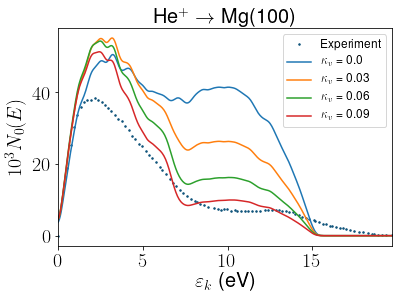

In [7]:
element = "Mg"
surface = "100"
ion = "He"
plasmon_range = np.arange(0.0, 0.1, 0.03)

quotas = QuotasCalculator.from_file(
    os.path.join(data_dir, element + "_" + surface + "_pbe.json")
)
exp_see = exp_data[element][ion]

# Plot the yield densities
fig, ax = plt.subplots()
ax.plot(exp_see["energy"], exp_see["yield"], "o", 
        color="#11557C", markersize=1.5)

rc_font_dict = {"size": 20, "family": "sans-serif", 
                "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
plt.rc("font", **rc_font_dict)
font_dict = {"size": 20, "family": "sans-serif", "name": 'DejaVu Sans'}
legend_items = ["Experiment"]
for plasmon in plasmon_range:
    
    legend_items.append("$\kappa_v$ = " + str(round(plasmon, 2)))
    plasmon_pars={"bulk_parameter": plasmon, "surface_parameter": 0}
    quotas.set_up_plasmon_probabilities(**plasmon_pars)
    
    calc_see = quotas.calculate_yield(ionization_energies[ion])
    
    ax.plot(calc_see["energy"], 
             get_smeared_densities(calc_see["energy"], 
                                   calc_see["yield"]*1e3, 
                                   density_smearing))

# Configure the axes
ax.set_xlim([0, max(exp_see["energy"])])
ax.set_xlabel(r"$\varepsilon_k$ (eV)")
ax.set_ylabel(r"$10^3 N_0 (E)$")
ax.set_title(ion + r"$^+$ $\rightarrow$ " + element + "(" + surface + ")", 
             fontdict=font_dict)
plt.legend(legend_items, fontsize=12)
tikzplotlib.save(os.path.join(figures_dir, "bulk_plasmon_inf.tex"))

## Ne$^+$ $\rightarrow$ Be (110)

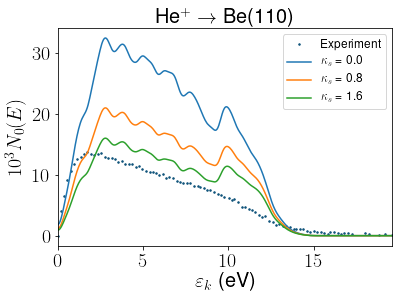

In [8]:
element = "Be"
surface = "110"
ion = "He"
plasmon_range = np.arange(0.0, 1.7, 0.8)

quotas = QuotasCalculator.from_file(
    os.path.join(data_dir, element + "_" + surface + "_pbe.json")
)
exp_see = exp_data[element][ion]

# Plot the yield densities
fig, ax = plt.subplots()
ax.plot(exp_see["energy"], exp_see["yield"], "o", 
        color="#11557C", markersize=1.5)

rc_font_dict = {"size": 20, "family": "sans-serif", 
                "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
plt.rc("font", **rc_font_dict)
font_dict = {"size": 20, "family": "sans-serif", "name": 'DejaVu Sans'}
legend_items = ["Experiment"]
for plasmon in plasmon_range:
    
    legend_items.append("$\kappa_s$ = " + str(round(plasmon, 1)))
    plasmon_pars={"bulk_parameter": 0, "surface_parameter": plasmon}
    quotas.set_up_plasmon_probabilities(**plasmon_pars)
    
    calc_see = quotas.calculate_yield(ionization_energies[ion])
    
    ax.plot(calc_see["energy"], 
             get_smeared_densities(calc_see["energy"], 
                                   calc_see["yield"]*1e3,
                                   density_smearing))

# Configure the axes
ax.set_xlim([0, max(exp_see["energy"])])
ax.set_xlabel(r"$\varepsilon_k$ (eV)")
ax.set_ylabel(r"$10^3 N_0 (E)$")
ax.set_title(ion + r"$^+$ $\rightarrow$ " + element + "(" + surface + ")", 
             fontdict=font_dict)
plt.legend(legend_items, fontsize=12)
tikzplotlib.save(os.path.join(figures_dir, "surface_plasmon_inf.tex"))

## Energy loss functions

In [9]:
Al_quotas = QuotasCalculator.from_file(os.path.join(data_dir, "Al_100_pbe.json"))
Mg_quotas = QuotasCalculator.from_file(os.path.join(data_dir, "Mg_100_pbe.json"))
Be_quotas = QuotasCalculator.from_file(os.path.join(data_dir, "Be_100_pbe.json"))

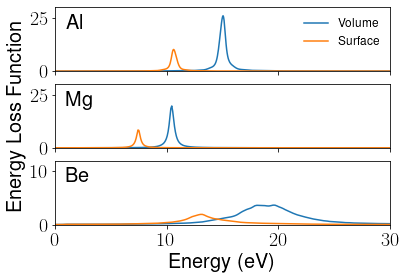

In [10]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(Al_quotas.dieltensor.energies,
           Al_quotas.dieltensor.get_loss_function())
ax[1].plot(Mg_quotas.dieltensor.energies, 
           Mg_quotas.dieltensor.get_loss_function())
ax[2].plot(Be_quotas.dieltensor.energies, 
           Be_quotas.dieltensor.get_loss_function())
ax[0].plot(Al_quotas.dieltensor.energies, 
           Al_quotas.dieltensor.get_loss_function(surface=True))
ax[1].plot(Mg_quotas.dieltensor.energies, 
           Mg_quotas.dieltensor.get_loss_function(surface=True))
ax[2].plot(Be_quotas.dieltensor.energies, 
           Be_quotas.dieltensor.get_loss_function(surface=True))

ax[0].set_ylim([0, 30]);
ax[1].set_ylim([0, 30]);
ax[2].set_ylim([0, 12]);
ax[0].set_xlim([0, 30]);

ax[0].text(1, 20, "Al")
ax[1].text(1, 20, "Mg")
ax[2].text(1, 8, "Be")
ax[2].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Energy Loss Function")
ax[0].legend(["Volume", "Surface"], fontsize=12, frameon=False)
tikzplotlib.save("test.tex")
plt.savefig(os.path.join(figures_dir, "energy_loss.eps"), format="eps", bbox_inches="tight")
tikzplotlib.save(os.path.join(figures_dir, "energy_loss.tex"))

## Results

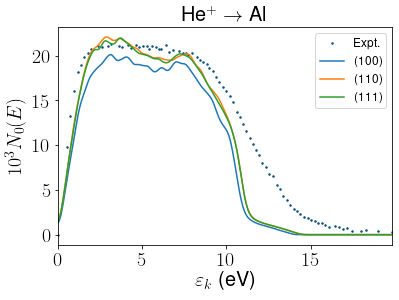

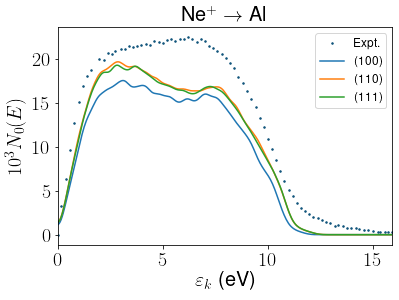

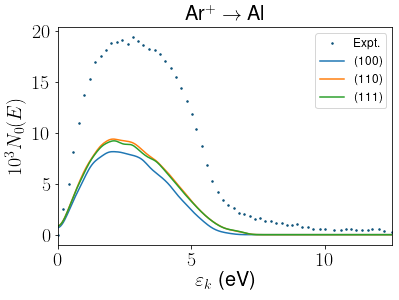

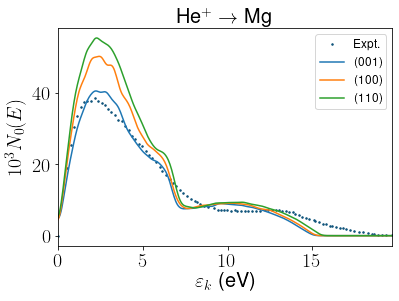

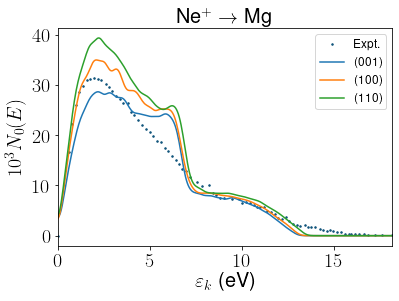

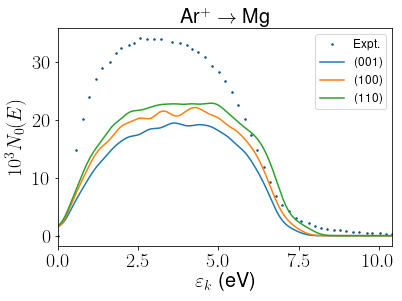

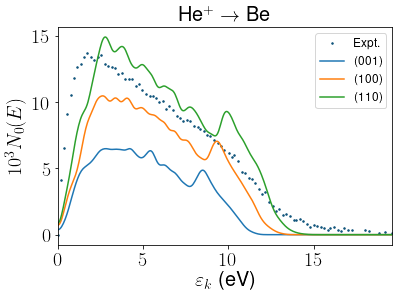

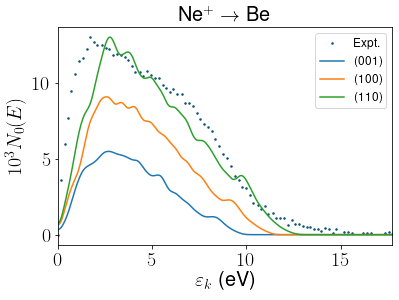

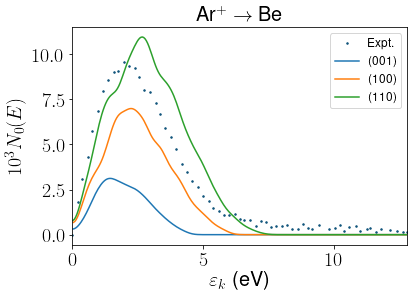

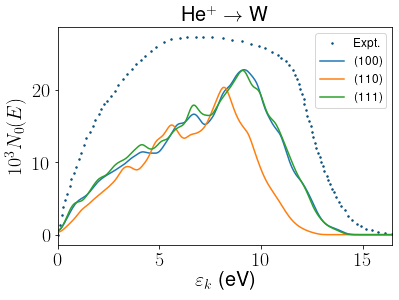

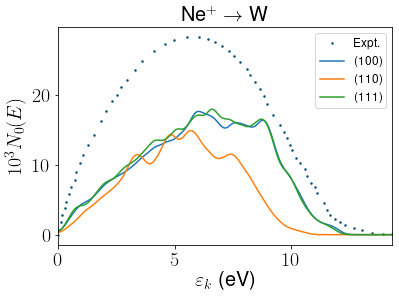

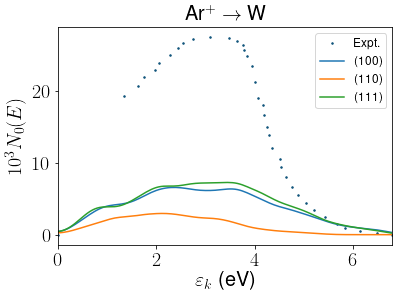

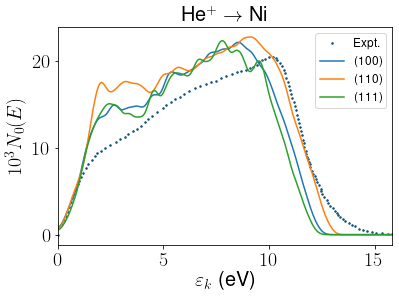

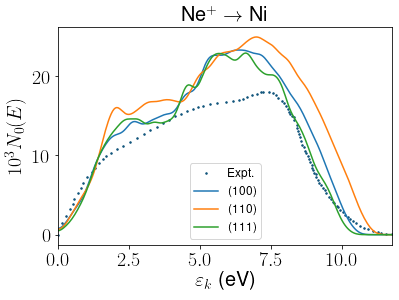

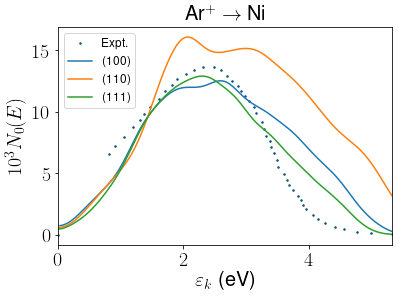

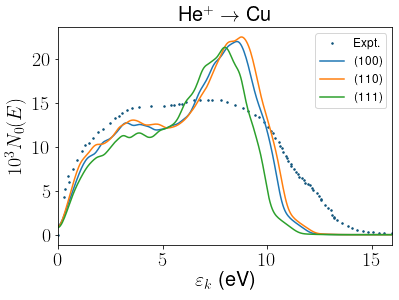

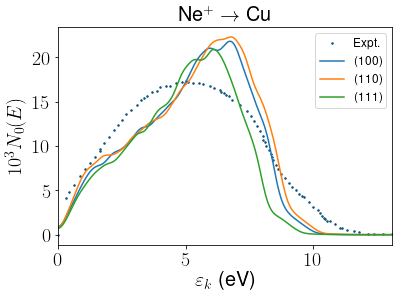

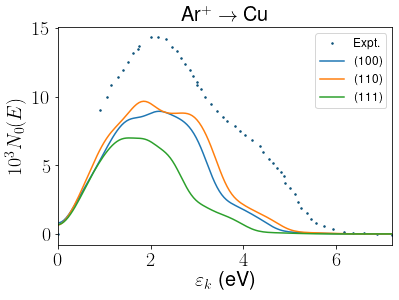

In [11]:
for element in ["Al", "Mg", "Be", "W", "Ni", "Cu"]:
    
    surfaces = structure_dict[element]["slabs"].keys()
    
    for ion in ["He", "Ne", "Ar"]:
        exp_see = exp_data[element][ion]

        # Plot the yield densities
        fig, ax = plt.subplots()
        ax.plot(exp_see["energy"], exp_see["yield"], "o", 
                color="#11557C", markersize=1.5)

        rc_font_dict = {"size": 20, "family": "sans-serif", 
                        "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
        plt.rc("font", **rc_font_dict)
        font_dict = {"size": 20, "family": "sans-serif", "name": 'DejaVu Sans'}
        legend_items = ["Expt."]

        for surface in surfaces:

            quotas = QuotasCalculator.from_file(
                os.path.join(data_dir, element + "_" + surface + "_pbe.json")
            )

            legend_items.append("(" + surface + ")")

            calc_see = quotas.calculate_yield(ionization_energies[ion])

            ax.plot(calc_see["energy"], 
                     get_smeared_densities(calc_see["energy"], 
                                           calc_see["yield"] * 1e3,
                                           density_smearing))

        # Configure the axes
        ax.set_xlim([0, max(exp_see["energy"])])
        ax.set_xlabel(r"$\varepsilon_k$ (eV)")
        ax.set_ylabel(r"$10^3 N_0 (E)$")
        ax.set_title(ion + r"$^+$ $\rightarrow$ " + element, 
                     fontdict=font_dict)
        plt.legend(legend_items, fontsize=12)
        tikzplotlib.save(os.path.join(figures_dir, ion + element + "_results.tex"))


## Influence of d-orbitals on Cu(110)

Total yield = 0.14517549531215598
Total yield (high d) = 0.14570659501419664


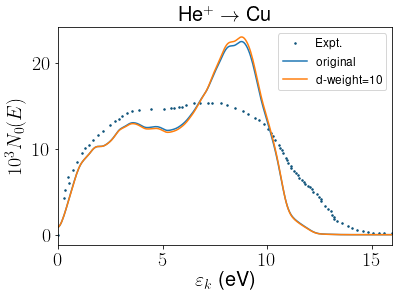

In [12]:
element = "Cu"
ion = "He"
surface = "110"
d_weight = 10

exp_see = exp_data[element][ion]

q = QuotasCalculator.from_file(os.path.join(data_dir, element + "_" + surface + "_pbe.json"))

see = q.calculate_yield(ionization_energies[ion])
see_d = q.calculate_yield(ionization_energies[ion], d_electron_weight=d_weight)
print("Total yield = " + str(see["total_yield"]))
print("Total yield (high d) = " + str(see_d["total_yield"]))  

rc_font_dict = {"size": 20, "family": "sans-serif", 
                "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
plt.rc("font", **rc_font_dict)
font_dict = {"size": 20, "family": "sans-serif", "name": 'DejaVu Sans'}
legend_items = ["Expt.", "original", "d-weight=10"]

# Plot the yield densities
fig, ax = plt.subplots()
ax.plot(exp_see["energy"], exp_see["yield"], "o", 
        color="#11557C", markersize=1.5)
ax.plot(see["energy"], 
         get_smeared_densities(see["energy"], 
                               see["yield"] * 1e3,
                               density_smearing))
ax.plot(see_d["energy"], 
         get_smeared_densities(see_d["energy"], 
                               see_d["yield"] * 1e3,
                               density_smearing))

# Configure the axes
ax.set_xlim([0, max(exp_see["energy"])])
ax.set_xlabel(r"$\varepsilon_k$ (eV)")
ax.set_ylabel(r"$10^3 N_0 (E)$")
ax.set_title(ion + r"$^+$ $\rightarrow$ " + element, 
             fontdict=font_dict)
plt.legend(legend_items, fontsize=12)
tikzplotlib.save(os.path.join(figures_dir, "d_influence.tex"))

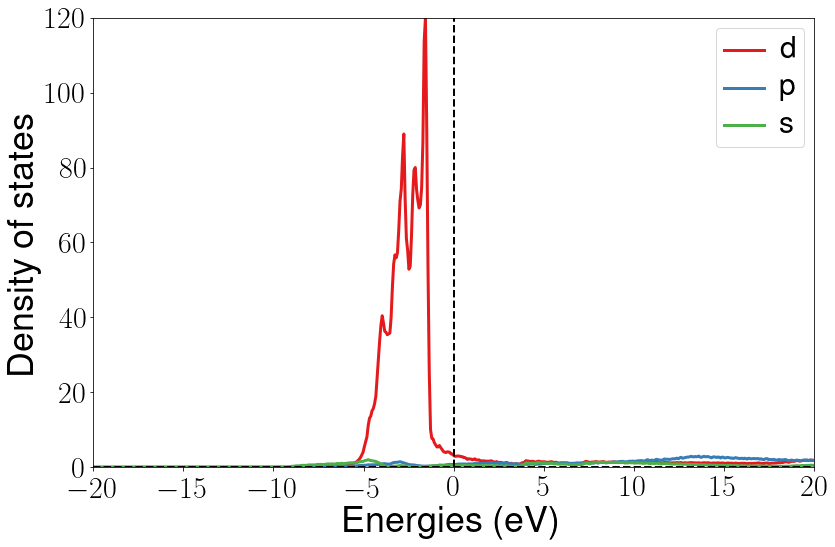

In [13]:
element = "Cu"
surface = "110"

q = QuotasCalculator.from_file(os.path.join(data_dir, element + "_" + surface + "_pbe.json"))
cdos = q.cdos
dpl = DosPlotter()

dpl.add_dos_dict(cdos.get_element_spd_dos(element.split("_")[0]))
plt = dpl.get_plot(xlim=[-20, 20],ylim=[0, 120])
tikzplotlib.save(os.path.join(figures_dir, "Cu_110_pdos.tex"))

## PDOS of low yield elements

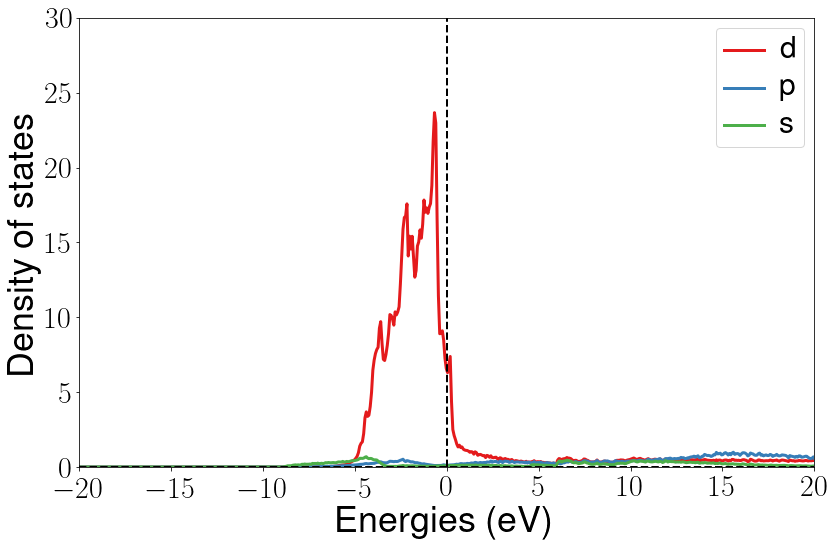

In [14]:
element = "Ni"
surface = "100"

q = QuotasCalculator.from_file(os.path.join(data_dir, element + "_" + surface + "_pbe.json"))
cdos = q.cdos
dpl = DosPlotter()

dpl.add_dos_dict(cdos.get_element_spd_dos(element.split("_")[0]))
plt = dpl.get_plot(xlim=[-20, 20],ylim=[0, 30])
tikzplotlib.save(os.path.join(figures_dir, element + "_"+ surface + "_pdos_new.tex"))